In [1]:
import numpy as np
import pandas as pd
import warnings
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [2]:
train_orig = pd.read_csv("data/titanic/train.csv")
test_orig = pd.read_csv("data/titanic/test.csv")
display(train_orig.head())
display(test_orig.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
print("train_orig rows: " + str(train_orig.shape[0]))
display(train_orig.describe())
print("#NaNs:")
print(train_orig.isnull().sum())

train_orig rows: 891


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#NaNs:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [4]:
print("test_orig rows: " + str(test_orig.shape[0]))
display(test_orig.describe())
print("#NaNs:")
print(test_orig.isnull().sum())

test_orig rows: 418


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


#NaNs:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [5]:
def extract_title(lst):
    return [i.split(",")[1].split(".")[0].strip() for i in lst]

train_title = extract_title(train_orig["Name"])
test_title = extract_title(test_orig["Name"])

title = train_title + test_title
from collections import Counter
print(Counter(title))

def convert_title(lst):
    return [i if i in ["Mr", "Miss", "Mrs", "Master"] else "Others" for i in lst]

train_orig["Title"] = convert_title(train_title)
test_orig["Title"] = convert_title(test_title)
display(train_orig["Title"].value_counts())
display(test_orig["Title"].value_counts())

Counter({'Mr': 757, 'Miss': 260, 'Mrs': 197, 'Master': 61, 'Rev': 8, 'Dr': 8, 'Col': 4, 'Ms': 2, 'Major': 2, 'Mlle': 2, 'Don': 1, 'Mme': 1, 'Lady': 1, 'Sir': 1, 'Capt': 1, 'the Countess': 1, 'Jonkheer': 1, 'Dona': 1})


Mr        517
Miss      182
Mrs       125
Master     40
Others     27
Name: Title, dtype: int64

Mr        240
Miss       78
Mrs        72
Master     21
Others      7
Name: Title, dtype: int64

In [6]:
train_orig["Age"] = train_orig["Age"].fillna(train_orig["Age"].median())
train = train_orig.dropna()

# features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
features = ["Pclass", "Sex", "Age", "Fare", "Title"]
train_x = train.loc[:, features]
train_y = train.loc[:, "Survived"]
test = test_orig.loc[:, features]

test["Age"] = test["Age"].fillna(test["Age"].median())
test["Fare"] = test["Fare"].fillna(test["Fare"].median())
# for column in ['Sex']:
for column in ["Sex", "Title"]:
# for column in ['Sex','Embarked']:
    le = preprocessing.LabelEncoder()
    le.fit(train_x[column].tolist() + test[column].tolist())
    train_x[column] = le.transform(train_x[column])
    test[column] = le.transform(test[column])

display(train_x.head())
display(train_x.describe())
display(test.head())
display(test.describe())

,Pclass,Sex,Age,Fare,Title
1,1,0,38.0,71.2833,3
3,1,0,35.0,53.1000,3
6,1,1,54.0,51.8625,2
10,3,0,4.0,16.7000,1
11,1,0,58.0,26.5500,1


,Pclass,Sex,Age,Fare,Title
count,202.000000,202.000000,202.000000,202.000000,202.000000
mean,1.198020,0.529703,34.952574,76.103301,2.044554
std,0.528205,0.500357,15.054584,74.759941,0.915861
min,1.000000,0.000000,0.920000,0.000000,0.000000
25%,1.000000,0.000000,25.000000,28.959375,1.000000
50%,1.000000,1.000000,33.500000,55.000000,2.000000
75%,1.000000,1.000000,46.750000,89.776050,3.000000
max,3.000000,1.000000,80.000000,512.329200,4.000000


,Pclass,Sex,Age,Fare,Title
0,3,1,34.5,7.8292,2
1,3,0,47.0,7.0000,3
2,2,1,62.0,9.6875,2
3,3,1,27.0,8.6625,2
4,3,0,22.0,12.2875,3


,Pclass,Sex,Age,Fare,Title
count,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,0.636364,29.599282,35.576535,1.918660
std,0.841838,0.481622,12.703770,55.850103,0.788458
min,1.000000,0.000000,0.170000,0.000000,0.000000
25%,1.000000,0.000000,23.000000,7.895800,2.000000
50%,3.000000,1.000000,27.000000,14.454200,2.000000
75%,3.000000,1.000000,35.750000,31.471875,2.000000
max,3.000000,1.000000,76.000000,512.329200,4.000000


In [7]:
### XGBoost

warnings.filterwarnings('ignore')

import xgboost as xgb

xgbclf = xgb.XGBClassifier()

# params = {
# #    'objective': ['binary:logistic'],
#     'learning_rate': [0.1],
#     'max_depth': [3],
#     'n_estimators': [15]
# }

params = {
    'objective': ['binary:logistic'],
#    'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3],
#    'reg_alpha': [0, 0.1, 0.2, 0.3, 1],
#    'gamma': [0.1, 0.2, 0.3, 0.4],
    'max_depth': [2, 3, 4, 5, 6],
    'n_estimators': [6, 8, 10, 12, 14, 16, 18]
}
xgbclf_cv = GridSearchCV(xgbclf, params, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=4, verbose=1)
# xgbclf_cv = GridSearchCV(xgbclf, params, cv=StratifiedKFold(n_splits=5), scoring='f1', verbose=1)
xgbclf_cv.fit(train_x, train_y)
print("### best params ###")
print(xgbclf_cv.best_params_, xgbclf_cv.best_score_)

display(train_x.head())

xgbclf = xgb.XGBClassifier(**xgbclf_cv.best_params_)
print(xgbclf)
xgbclf.fit(train_x, train_y)
print(xgbclf.score(train_x, train_y))
output = xgbclf.predict(test)
submit = pd.DataFrame({
    "PassengerId": np.array(test_orig["PassengerId"]).astype(int),
    "Survived": output
})

warnings.simplefilter("always")

Fitting 5 folds for each of 35 candidates, totalling 175 fits
### best params ###
{'max_depth': 2, 'n_estimators': 6, 'objective': 'binary:logistic'} 0.7673267326732673


[Parallel(n_jobs=4)]: Done 175 out of 175 | elapsed:    0.8s finished


,Pclass,Sex,Age,Fare,Title
1,1,0,38.0,71.2833,3
3,1,0,35.0,53.1000,3
6,1,1,54.0,51.8625,2
10,3,0,4.0,16.7000,1
11,1,0,58.0,26.5500,1


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=6,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
0.7920792079207921


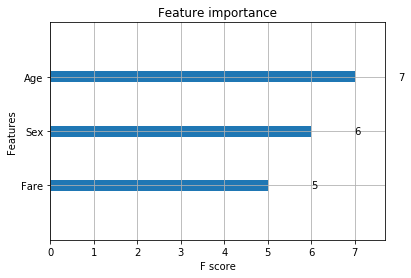

In [9]:
xgb.plot_importance(xgbclf);

In [33]:
### RandomForestClassifier with hyper parameter tuning (score: )

# warnings.filterwarnings('ignore')

# from sklearn import ensemble
# rfc = ensemble.RandomForestClassifier()

# params = {
#     "max_depth": [None],
#     "max_features": ['auto', None],
#     "max_depth": [2, 3, 4, 5, 6],
# #    "min_samples_split": [2, 3, 10],
# #    "min_samples_leaf": [1, 2, 3, 4, 5],
#     "bootstrap": [True, False],
# #    "n_estimators":  [6, 8, 10, 12, 14, 16, 18],
#     "criterion": ["gini"]
# }

# gsrfc = GridSearchCV(rfc, params, cv=StratifiedKFold(n_splits=5), n_jobs=4, verbose=1)
# gsrfc.fit(train_x, train_y)
# print(gsrfc.best_params_, xgbclf_cv.best_score_)

# rfc = ensemble.RandomForestClassifier(**gsrfc.best_params_)
# rfc.fit(train_x, train_y)
# print(rfc)
# print(gsrfc.score(train_x, train_y))

# output = rfc.predict(test)

# warnings.simplefilter("always")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto'} 0.7673267326732673
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.7970297029702971


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


In [9]:
### DecisionTreeClassifier with default settings (score: 0.58373)

# from sklearn import tree
# dtc = tree.DecisionTreeClassifier()
# dtc = dtc.fit(train_x.values, train_y.values)
# output = dtc.predict(test)

In [8]:
### RandomForestClassifier with default settings (score: 0.64593)

# from sklearn import ensemble
# rfc = ensemble.RandomForestClassifier()
# rfc.fit(train_x.values, train_y.values)
# output = rfc.predict(test)

In [34]:
submit = pd.DataFrame({
    "PassengerId": np.array(test_orig["PassengerId"]).astype(int),
    "Survived": output
})
print(submit.shape)
display(submit.head())
submit.to_csv("submit.csv", index=False)

(418, 2)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
